In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools
from dmba import regressionSummary
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import log
from statsmodels.tsa import tsatools, stattools
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from dateutil.parser import parse
import pmdarima as pm

%matplotlib inline
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES

no display found. Using non-interactive Agg backend


In [4]:
df=pd.read_csv("v_hungpq_test_mpg_cost_price.csv")

In [5]:
#df=df[df.columns[1:]]
df=df[['std_commodity','std_incoterms','std_size','std_value_usd_kg','std_active_date']]

In [6]:
df.head()

,std_commodity,std_incoterms,std_size,std_value_usd_kg,std_active_date
0,BT CPD,DDP LA,13/15,22.77,2018-06-08
1,BT CPD,DDP LA,16/20,18.19,2018-06-08
2,BT CPD,DDP LA,21/25,15.28,2018-06-08
3,BT CPD,DDP LA,26/30,13.05,2018-06-08
4,BT CPD,DDP LA,31/40,11.00,2018-06-08


In [7]:
name_of_incoterms=df['std_incoterms'].unique() # filter incoterms
name_of_incoterms

array(['DDP LA', 'FOB HCM'], dtype=object)

In [8]:
name_of_commodity=df['std_commodity'].unique()
name_of_commodity
# BT tom su
# VM Tom the

array(['BT CPD', 'BT CPTO', 'BT HLSO-O', 'BT RPD', 'BT RPTO', 'VM CPD',
       'VM CPTO', 'VM HLSO-O', 'VM RPD', 'VM RPTO'], dtype=object)

In [9]:
name_of_size=df['std_size'].unique()
name_of_size

array(['13/15', '16/20', '21/25', '26/30', '31/40', '41/50', '4/6',
       '51/60', '61/70', '6/8', '71/90', '8/12', '2/4', '91/120'],
      dtype=object)

In [10]:
# filter data sets by commondity, incorterms, size
df1=df[(df['std_commodity']==name_of_commodity[0])&
       (df['std_incoterms']==name_of_incoterms[0])&
       (df['std_size']==name_of_size[0])]

df2=df[(df['std_commodity']==name_of_commodity[0])&
       (df['std_incoterms']==name_of_incoterms[1])&
       (df['std_size']==name_of_size[0])]

In [11]:
df1.head()

,std_commodity,std_incoterms,std_size,std_value_usd_kg,std_active_date
0,BT CPD,DDP LA,13/15,22.77,2018-06-08
125,BT CPD,DDP LA,13/15,22.77,2018-06-09
250,BT CPD,DDP LA,13/15,22.77,2018-06-10
375,BT CPD,DDP LA,13/15,22.62,2018-06-12
500,BT CPD,DDP LA,13/15,22.46,2018-06-14


In [12]:
df2.head()

,std_commodity,std_incoterms,std_size,std_value_usd_kg,std_active_date
12,BT CPD,FOB HCM,13/15,22.13,2018-06-08
137,BT CPD,FOB HCM,13/15,22.13,2018-06-09
262,BT CPD,FOB HCM,13/15,22.13,2018-06-10
387,BT CPD,FOB HCM,13/15,21.98,2018-06-12
512,BT CPD,FOB HCM,13/15,21.85,2018-06-14


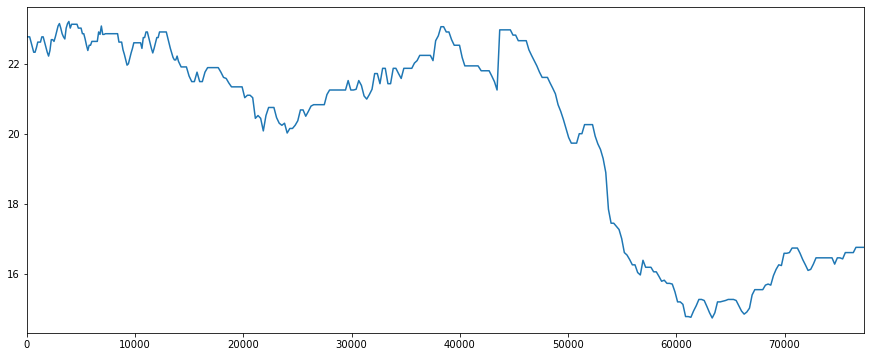

In [13]:
df1['std_value_usd_kg'].plot(figsize=(15,6))

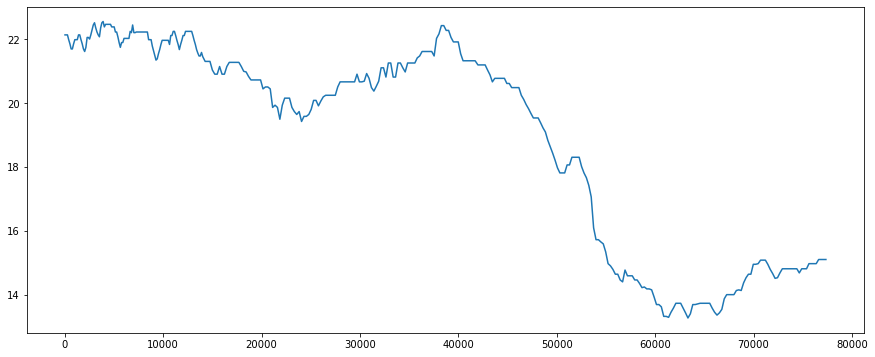

In [16]:
df2['std_value_usd_kg'].plot(figsize=(15,6))

In [15]:
df1=df1[['std_value_usd_kg','std_active_date']]
df1.index=pd.to_datetime(df1['std_active_date'])
df1=df1[df1.columns[0:1]]

In [16]:
df1.head()

,std_value_usd_kg
std_active_date,
2018-06-08,22.77
2018-06-09,22.77
2018-06-10,22.77
2018-06-12,22.62
2018-06-14,22.46


In [17]:
df2=df2[['std_value_usd_kg','std_active_date']]
df2.index=pd.to_datetime(df2['std_active_date'])
df2=df2[df2.columns[0:1]]

In [18]:
df2.head()

,std_value_usd_kg
std_active_date,
2018-06-08,22.13
2018-06-09,22.13
2018-06-10,22.13
2018-06-12,21.98
2018-06-14,21.85


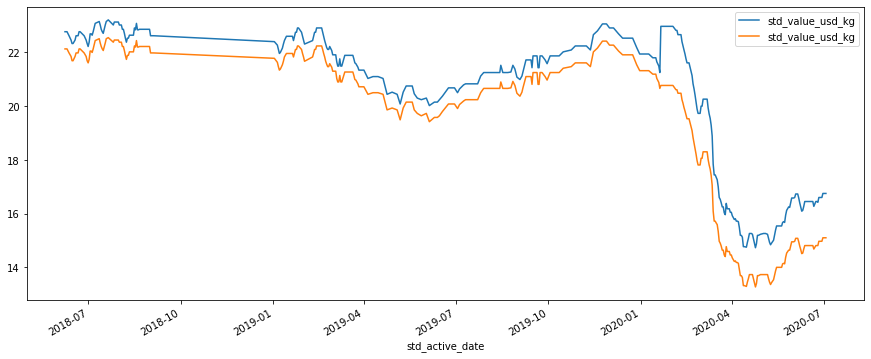

In [18]:
ax1=df1.plot(figsize=(15,6))
df2.plot(ax=ax1)

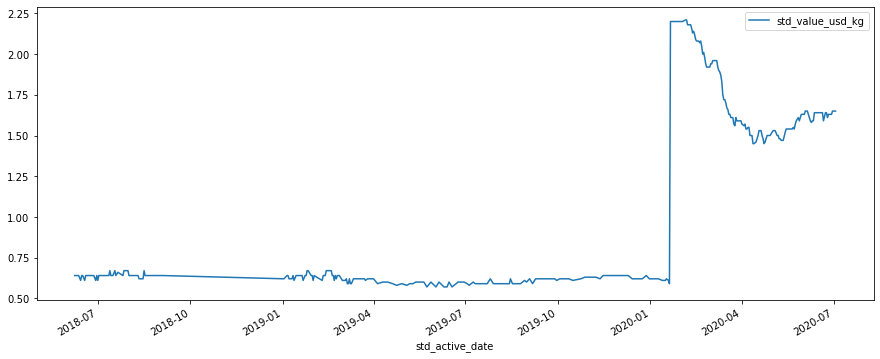

In [19]:
df3=df1-df2
df3.plot(figsize=(15,6))

In [20]:
def filling(df):
    tsnew=df.asfreq('d').index
    ts=df.index
    mask = tsnew.isin(ts)
    missing=tsnew[~mask]
    df0=pd.DataFrame([np.nan]*len(missing),index=missing,columns=df.columns)
    df1=pd.concat([df,df0],axis=0) 
    df2 = df1.sort_index()
    df3=df2.fillna(method='bfill') #method{‘backfill’, ‘bfill’, ‘pad’, ‘ffill’, None},

    return df3

In [21]:
df1_fill=filling(df1)

In [22]:
df1_fill=df1_fill.set_index(df1.asfreq('d').index)
df1_fill.index

DatetimeIndex(['2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11',
               '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15',
               '2018-06-16', '2018-06-17',
               ...
               '2020-06-24', '2020-06-25', '2020-06-26', '2020-06-27',
               '2020-06-28', '2020-06-29', '2020-06-30', '2020-07-01',
               '2020-07-02', '2020-07-03'],
              dtype='datetime64[ns]', name='std_active_date', length=757, freq='D')

In [23]:
#ax2=df1_fill.plot(figsize=(15,6))
#df1.plot(ax=ax2)
#len(df)

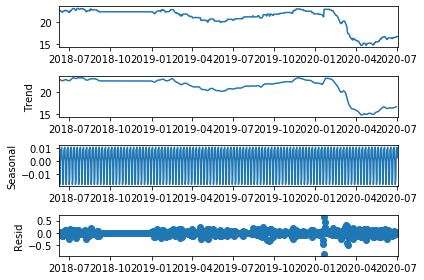

In [24]:
# Mô hình cộng tính
x=df1_fill
sd_add=seasonal_decompose(x,model='additive')
sd_add.plot()
plt.show()

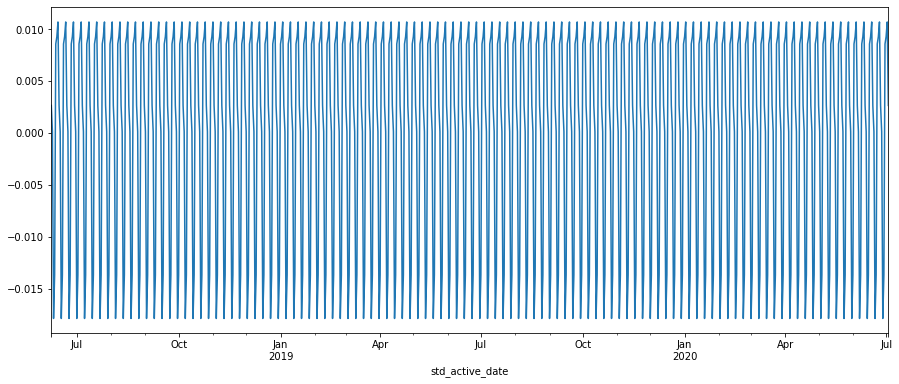

In [25]:
sd_add.seasonal.plot(figsize=(15,6))
plt.show()

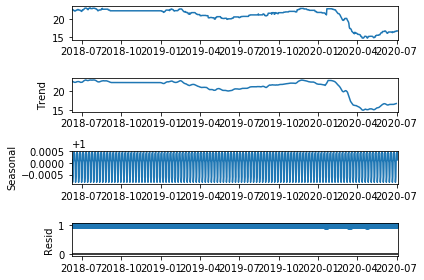

In [26]:
# Mô hình nhân
x=df1_fill
sd_mul=seasonal_decompose(x,model='multiplicative')
sd_mul.plot()
plt.show()

In [27]:
# ES
x=df1_fill
n=np.int(0.8*len(x))
train=x.iloc[:n]
test=x.iloc[n:]
ntest=len(x)-n


C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


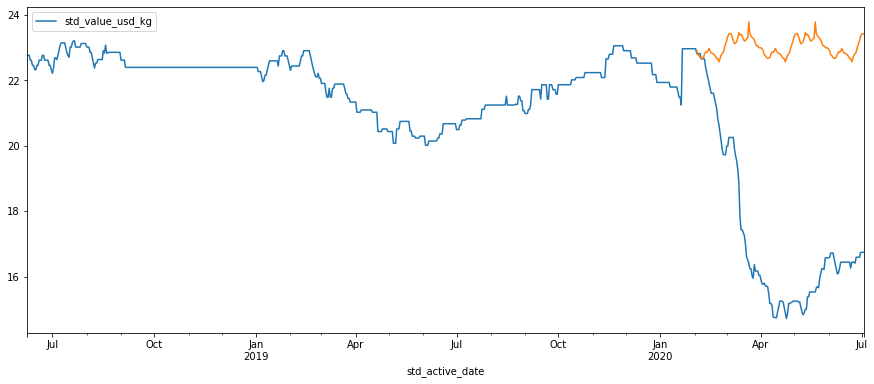

In [28]:
model=ES(train,trend='add',damped=True,seasonal='add',seasonal_periods=60).fit()
fc=model.forecast(ntest)
fc.index=test.index
#print('RMSE:', np.sqrt(mean_squared_error(test,fc)))
x.plot(figsize=(15,6))
fc.plot()
plt.show()

In [29]:
x=df1_fill.diff(1)[1:]
n=np.int(0.8*len(x))
train=x.iloc[:n]
test=x.iloc[n:]
ntest=len(x)-n

In [30]:
x.isnull().sum(),train.isnull().sum(),test.isnull().sum()

(std_value_usd_kg    0
 dtype: int64, std_value_usd_kg    0
 dtype: int64, std_value_usd_kg    0
 dtype: int64)

C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\tvlon\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


RMSE: 0.2094843530460692


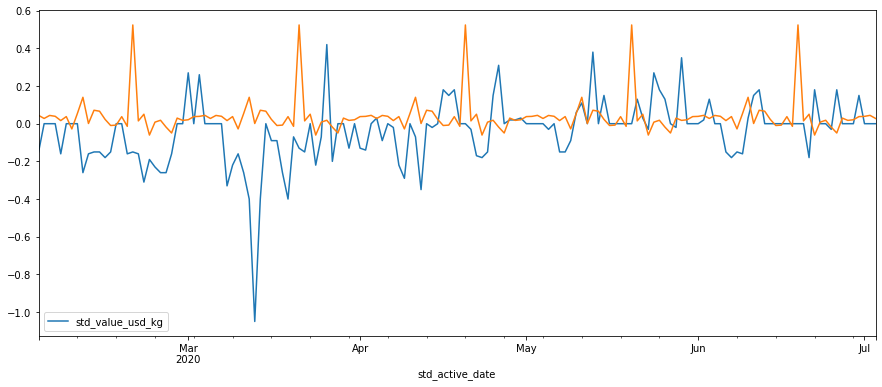

In [31]:
model=ES(train,trend='add',damped=True,seasonal='add',seasonal_periods=30).fit()
fc=model.forecast(ntest)
fc.index=test.index
print('RMSE:', np.sqrt(mean_squared_error(test,fc)))
#x.plot(figsize=(15,6))
test.plot(figsize=(15,6))
fc.plot()
plt.show()

In [32]:
x=df1_fill-df1_fill.rolling(7).mean()

x=x.dropna()
n=np.int(0.8*len(x))
train=x.iloc[:n]
test=x.iloc[n:]
ntest=len(x)-n

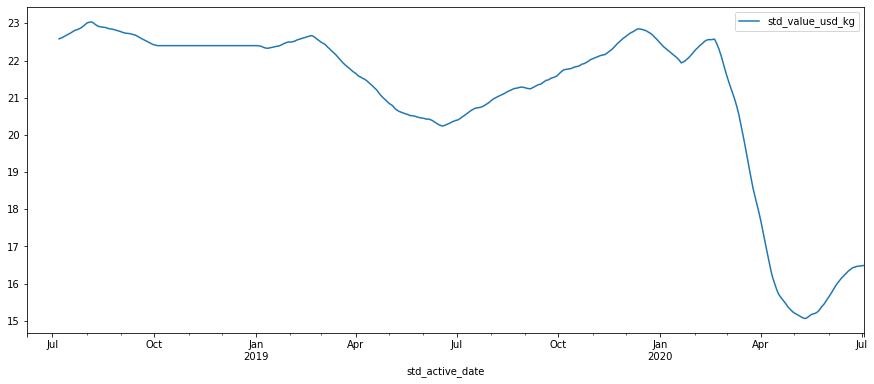

In [35]:
df1_fill.rolling(30).mean().plot(figsize=(15,6))

RMSE: 0.33528284432117667


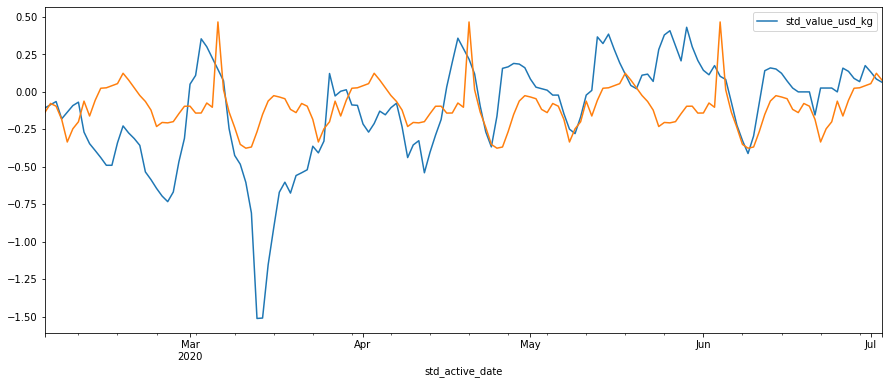

In [167]:
import warnings
warnings.filterwarnings("ignore")

model=ES(train,trend='add',damped=True,seasonal='add',seasonal_periods=45).fit()
fc=model.forecast(ntest)
fc.index=test.index
print('RMSE:', np.sqrt(mean_squared_error(test,fc)))
#x.plot(figsize=(15,6))
test.plot(figsize=(15,6))
fc.plot()
plt.show()

In [172]:
pred=fc+
    df1_fill[df1_fill.columns[0]].rolling(7).mean()[-ntest:].values

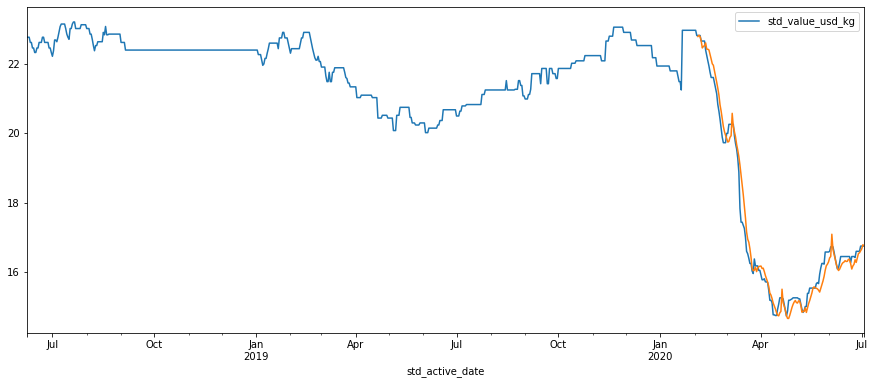

In [175]:
df1_fill.plot(figsize=(15,6))
pred.plot()
plt.show()

In [150]:
RMSE=[]
for m in range(2,60):
    model=ES(train,trend='add',damped=True,seasonal='add',seasonal_periods=m).fit()
    fc=model.forecast(ntest)
    fc.index=test.index
    #print('RMSE:', np.sqrt(mean_squared_error(test,fc)))
    RMSE.append(np.sqrt(mean_squared_error(test,fc)))

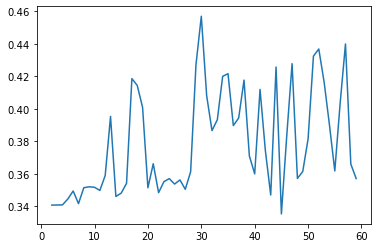

In [153]:
plt.plot(range(2,60),RMSE)

In [156]:
np.argmin(RMSE)

43

In [160]:
RMSE[43]

0.33528284432117667

In [163]:
range(2,60)[43]

45

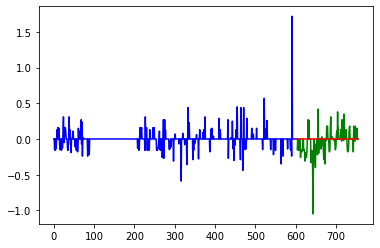

In [128]:
#train,test
model=pm.auto_arima(train,seasonal=True,m=12,suppress_warnings=True)
fc=model.predict(test.shape[0])
t=np.arange(x.shape[0])
plt.plot(t[:n],train,c='blue')
plt.plot(t[n:],test,c='green')
plt.plot(t[n:],fc,c='red')
plt.show()

In [ ]:
# Gia co so DDP LA
